In [1]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#PATH 

initial_path = '../CreateStudy'

# Change this value
participant_id = 'H005'
dominant_hand = 'Right'

# Join the initial_path and participant_id
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\H005


In [3]:
# Get the data from csv files 
ndh_data, chest_data, dh_data, GT_mask_ndh, GT_mask_dh = get_data(participant_path)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_ndh)*2, len(ndh_data))

35368 35368


In [4]:
# Get some usefull variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz

In [5]:
#Compute Actigraph Activity Count 
count_brond_ndh, processed_data_ndh = get_counts_brond(ndh_data)
count_brond_dh, processed_data_dh = get_counts_brond(dh_data)
#count_neish_ndh = get_counts_neishabouri(acc_ndh)
#count_neish_dh = get_counts_neishabouri(acc_dh)
AC_ndh = np.array(count_brond_ndh['AC Brond'])
AC_dh = np.array(count_brond_dh['AC Brond'])

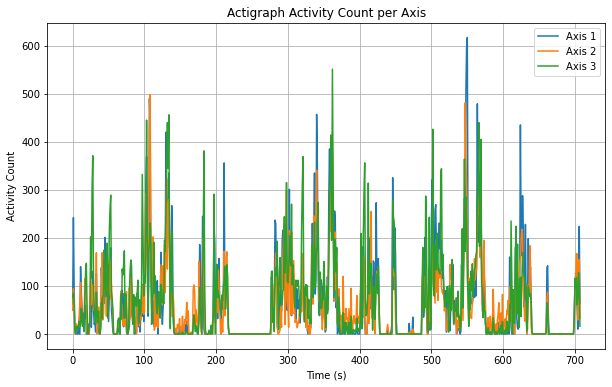

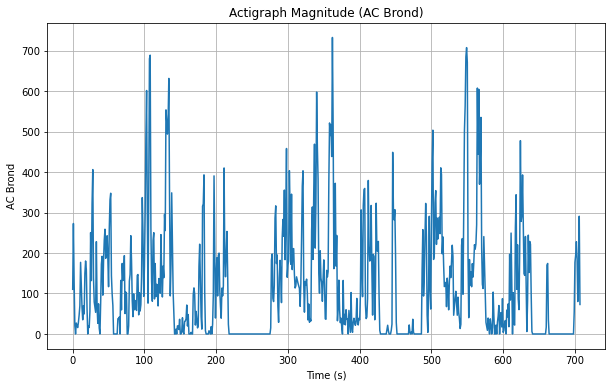

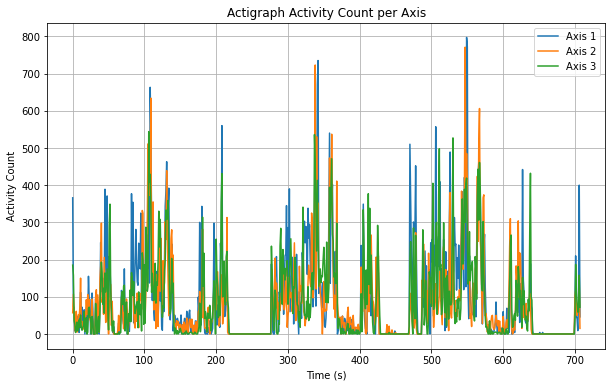

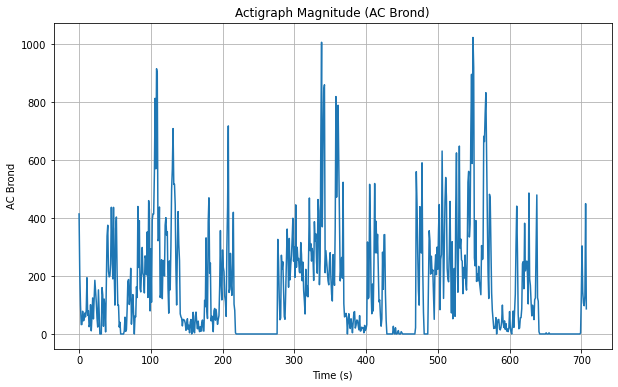

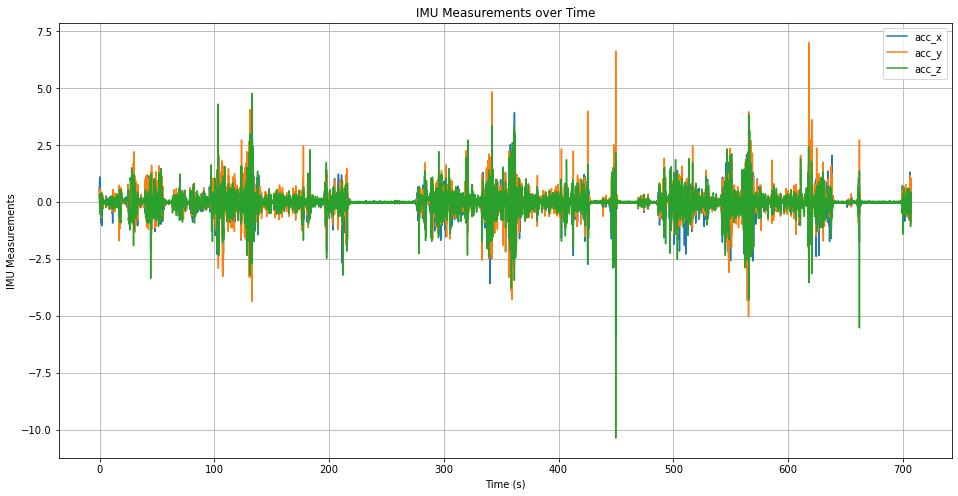

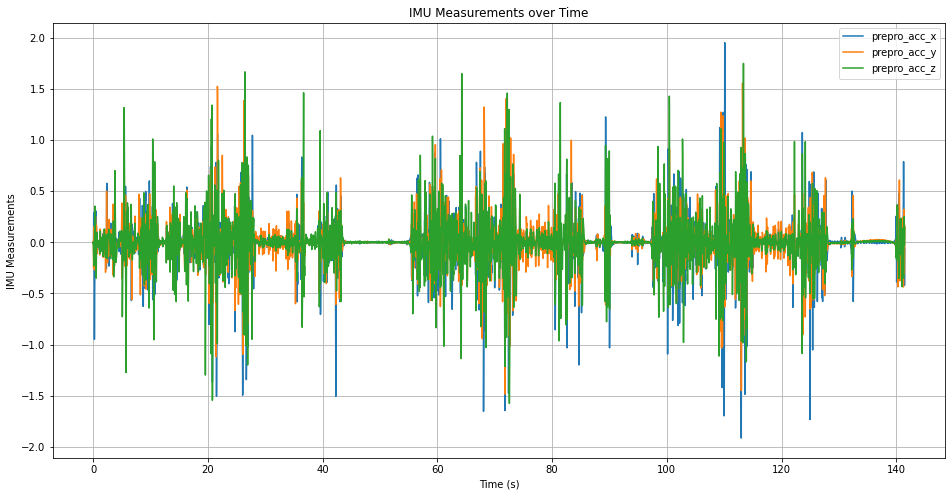

In [6]:
plot_actigraph_count(count_brond_ndh), plot_actigraph_count(count_brond_dh)
plot_raw_data(acc_ndh, sampling_freq)
plot_raw_data(processed_data_ndh, sampling_freq)

In [7]:
# MASK #

In [8]:
GT_mask_ndh_1Hz = resample_mask(GT_mask_ndh, FPS_mask, frequency_AC)
GT_mask_dh_1Hz = resample_mask(GT_mask_dh, FPS_mask, frequency_AC)
GT_mask_ndh_2Hz = resample_mask(GT_mask_ndh, FPS_mask, frequency_GM)
GT_mask_dh_2Hz = resample_mask(GT_mask_dh, FPS_mask, frequency_GM)

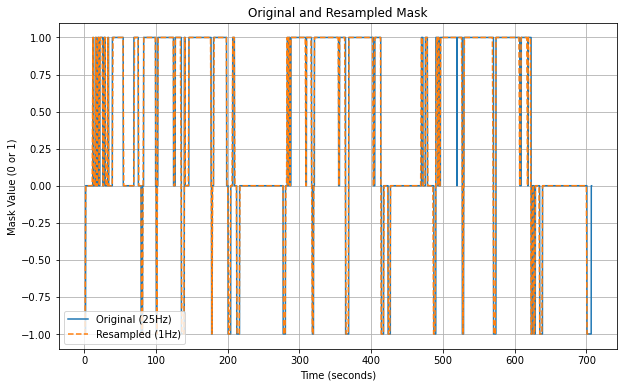

In [9]:
plot_resampled_arrays(GT_mask_dh, FPS_mask, GT_mask_dh_1Hz, frequency_AC)

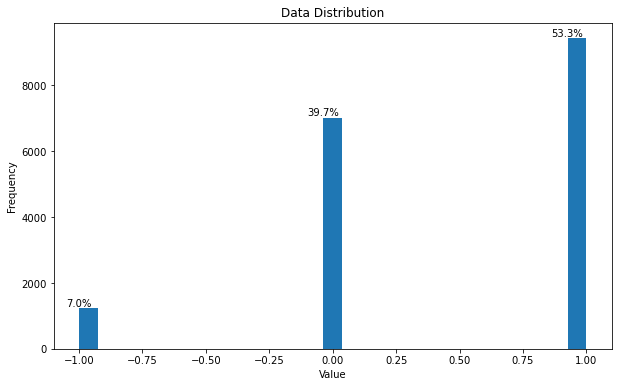

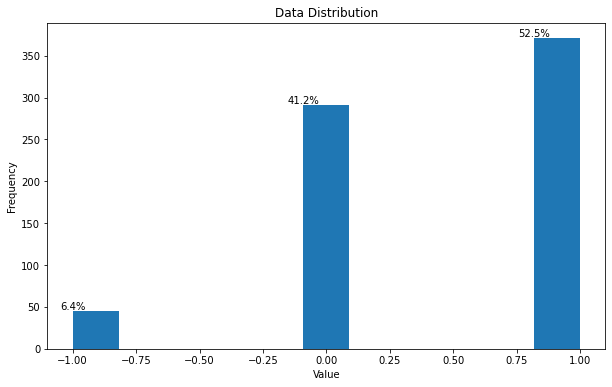

({'mean': 0.46358289979642614,
  'median': 1.0,
  'iqr': 1.0,
  'range': 2,
  'std': 0.6232665346654949,
  'max': 1,
  'min': -1,
  'num_elements': 17684},
 {'mean': 0.4611032531824611,
  'median': 1.0,
  'iqr': 1.0,
  'range': 2,
  'std': 0.6130134478273209,
  'max': 1,
  'min': -1,
  'num_elements': 707})

In [10]:
get_statistics(GT_mask_ndh), get_statistics(GT_mask_ndh_1Hz)

In [11]:
# MASK with WBM replaced by NF #

In [12]:
# Create masks with WBM converted into NF movement

# Replace WBM mask by NF masks @ 25Hz 
GT_mask_ndh_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh).ravel()
GT_mask_dh_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh).ravel()

# Replace WBM mask by NF masks @ 2Hz 
GT_mask_ndh_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh_2Hz)
GT_mask_dh_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh_2Hz)

# Replace WBM mask by NF masks @ 1Hz 
GT_mask_ndh_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh_1Hz)
GT_mask_dh_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh_1Hz)

# Trim dataset to ensure same size 
GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh = remove_extra_elements(GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh)
GT_mask_dh_1Hz_wbm_into_nf, AC_dh = remove_extra_elements(GT_mask_dh_1Hz_wbm_into_nf, AC_dh)

In [13]:
# Save mask @ 1 Hz needed for the group analysis 
save_resampled_masks_as_csv(GT_mask_ndh_1Hz_wbm_into_nf, GT_mask_dh_1Hz_wbm_into_nf, participant_path)

CSV files saved successfully.
ND-hand mask CSV saved at: ../CreateStudy\H005\GT_mask_ndh_1Hz.csv
D-hand mask CSV saved at: ../CreateStudy\H005\GT_mask_dh_1Hz.csv


In [14]:
# Save the AC values @ 1 Hz for the group analysis 
save_AC_as_csv(AC_ndh, AC_dh, participant_path)

CSV files saved successfully.
ND-hand AC CSV saved at: ../CreateStudy\H005\count_brond_ndh.csv
D-hand AC CSV saved at: ../CreateStudy\H005\count_brond_dh.csv


In [15]:
# Ensure the two arrays have the same size 
AC_ndh.shape, GT_mask_ndh_1Hz_wbm_into_nf.shape

((707,), (707,))

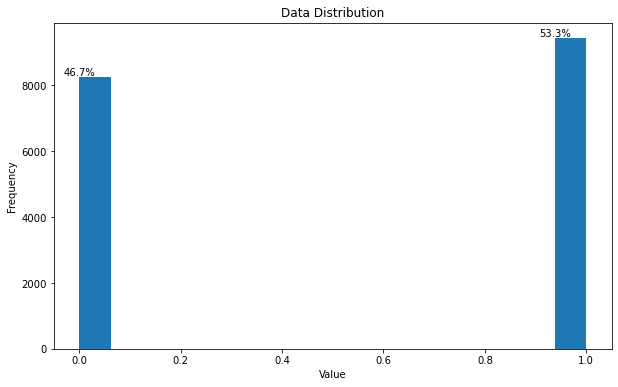

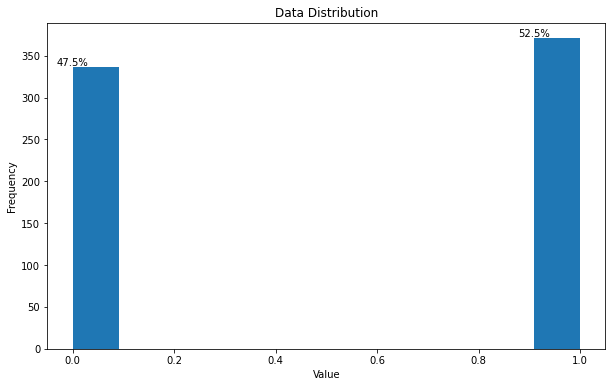

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


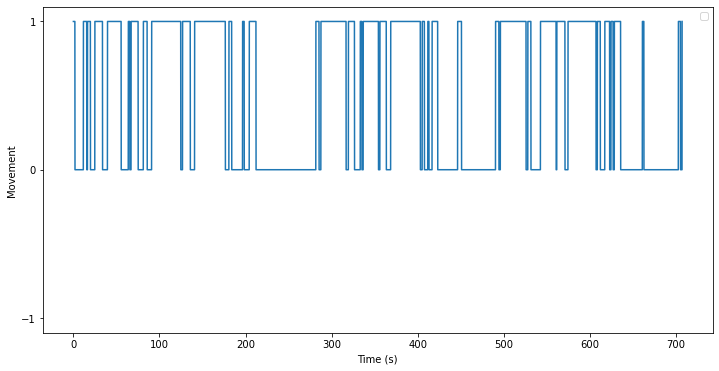

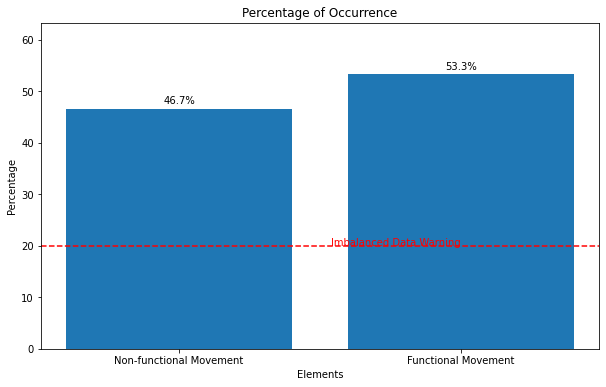

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


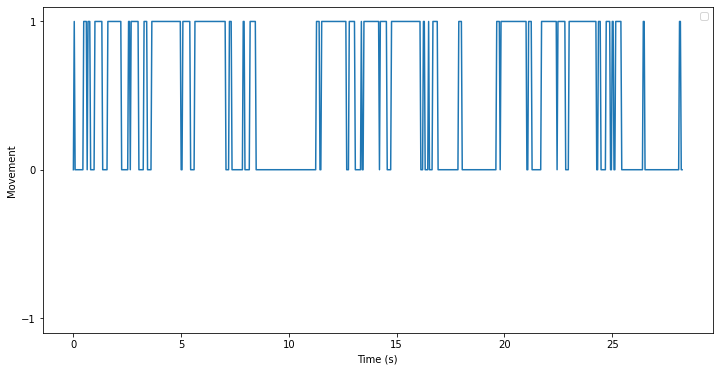

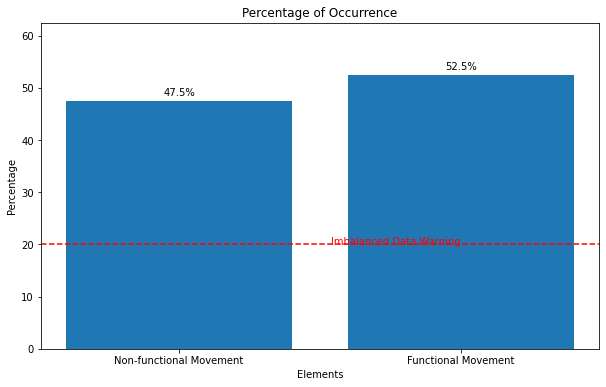

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


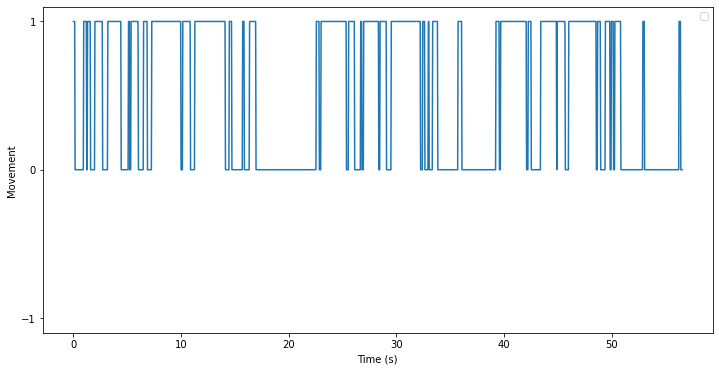

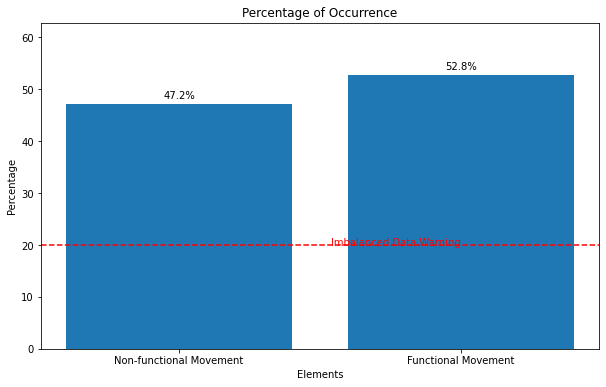

(None, None, None)

In [16]:
# Ensure the downsampling conserve the tendency 
get_statistics(GT_mask_ndh_wbm_into_nf), get_statistics(GT_mask_ndh_1Hz_wbm_into_nf)
plot_movement_tendency(GT_mask_ndh_wbm_into_nf), plot_movement_tendency(GT_mask_ndh_1Hz_wbm_into_nf), plot_movement_tendency(GT_mask_ndh_2Hz_wbm_into_nf)

In [17]:
# MASK with WBM removed #

In [18]:
# # Create the dataset without WBM ie removed from the analysis 
GT_mask_ndh_1Hz_no_wbm, count_brond_ndh_no_wbm = remove_wbm_data(GT_mask_ndh_1Hz, AC_ndh)
GT_mask_dh_1Hz_no_wbm, count_brond_dh_no_wbm = remove_wbm_data(GT_mask_dh_1Hz, AC_dh)

In [19]:
# Compare masks and AC #

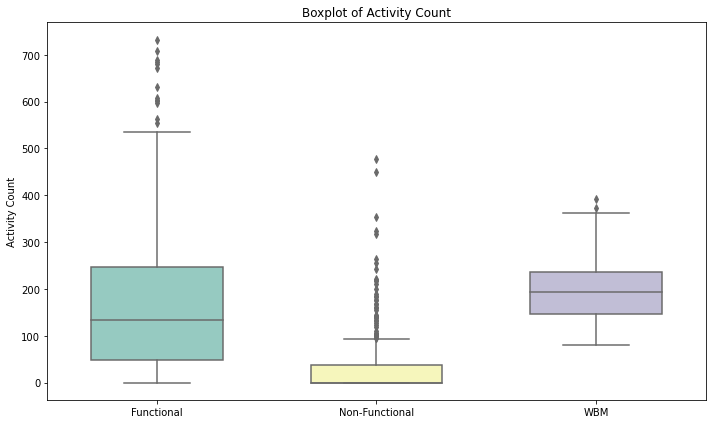

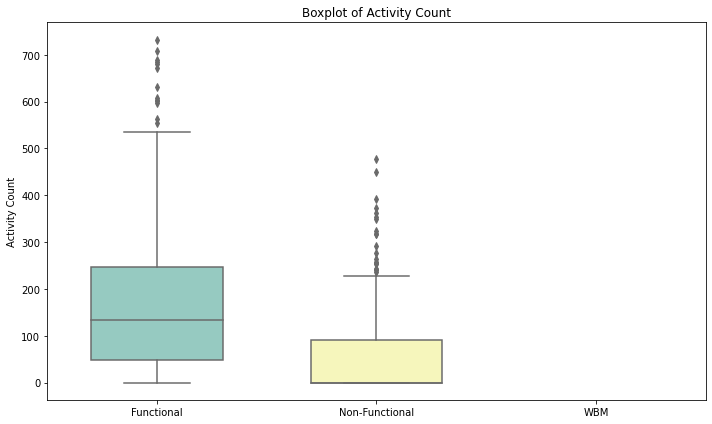

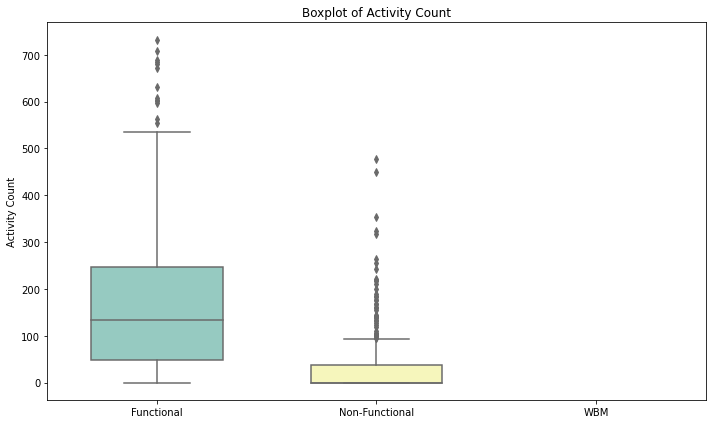

In [20]:
# Original maks with the WBM label
plot_ac_tendency(GT_mask_ndh_1Hz, AC_ndh)
# Option1: WBM into NF 
plot_ac_tendency(GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh)
# Option2: WBM data removed completely 
plot_ac_tendency(GT_mask_ndh_1Hz_no_wbm, count_brond_ndh_no_wbm)

In [21]:
# Splitting the data for the left wrist
X_ndh = AC_ndh
y_ndh = GT_mask_ndh_1Hz_wbm_into_nf

# Perform k-fold cross-validation for the left wrist data
# Optimal: Return average optimal AC threshold and average evaluation metrics 
eval_metrics_opt_ndh, opt_threshold_ndh = k_fold_cross_validation(X_ndh, y_ndh, optimal=True)

# Conventional: Return conventional AC threshold and average evaluation metrics 
eval_metrics_conv_ndh, conv_threshold_ndh = k_fold_cross_validation(X_ndh, y_ndh, optimal=False)

Iteration 1/5
AUC: 0.79
Optimal Threshold: 29.23
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 2/5
AUC: 0.80
Optimal Threshold: 15.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 3/5
AUC: 0.78
Optimal Threshold: 24.33
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 4/5
AUC: 0.78
Optimal Threshold: 24.33
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 5/5
AUC: 0.78
Optimal Threshold: 32.14
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 1/5
Using conventional threshold
Iteration 2/5
Using conventional threshold
Iteration 3/5
Using conventional threshold
Iteration 4/5
Using conventional threshold
Iteration 5/5
Using conventional threshold


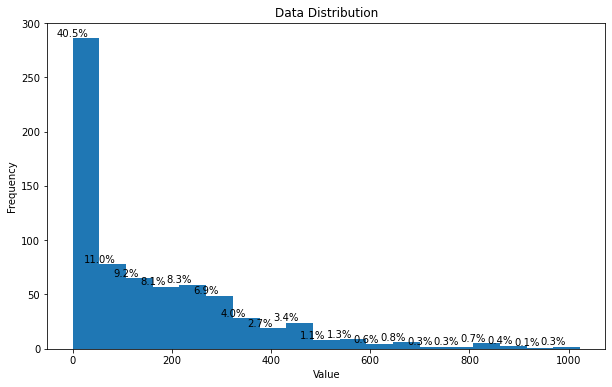

{'mean': 161.76486925668166, 'median': 99.34284070832683, 'iqr': 245.4682555969139, 'range': 1022.7389696300811, 'std': 187.28061693323966, 'max': 1022.7389696300811, 'min': 0.0, 'num_elements': 707}


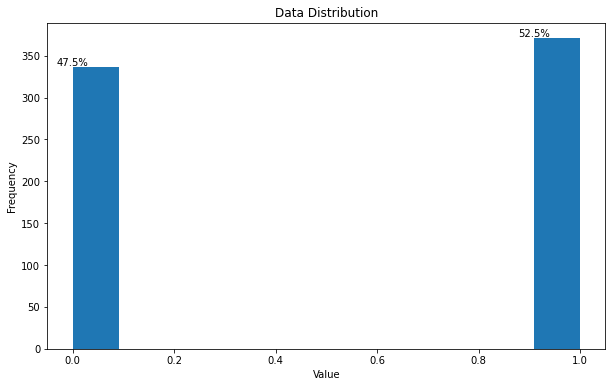

{'mean': 0.5247524752475248, 'median': 1.0, 'iqr': 1.0, 'range': 1, 'std': 0.4993869391254849, 'max': 1, 'min': 0, 'num_elements': 707}
Iteration 1/5
AUC: 0.72
Optimal Threshold: 7.82
Conventional Threshold: 2.00
AUC is not clinically useful (<0.75)
Iteration 2/5
AUC: 0.74
Optimal Threshold: 7.81
Conventional Threshold: 2.00
AUC is not clinically useful (<0.75)
Iteration 3/5
AUC: 0.73
Optimal Threshold: 7.81
Conventional Threshold: 2.00
AUC is not clinically useful (<0.75)
Iteration 4/5
AUC: 0.72
Optimal Threshold: 7.81
Conventional Threshold: 2.00
AUC is not clinically useful (<0.75)
Iteration 5/5
AUC: 0.74
Optimal Threshold: 7.08
Conventional Threshold: 2.00
AUC is not clinically useful (<0.75)
Iteration 1/5
Using conventional threshold
Iteration 2/5
Using conventional threshold
Iteration 3/5
Using conventional threshold
Iteration 4/5
Using conventional threshold
Iteration 5/5
Using conventional threshold


In [22]:
# Splitting the data for the right wrist
X_dh = AC_dh
y_dh = GT_mask_ndh_1Hz_wbm_into_nf

print(get_statistics(X_dh))
print(get_statistics(y_dh))

# Perform k-fold cross-validation for the right wrist data
# Optimal: Return average optimal AC threshold and average evaluation metrics 
eval_metrics_opt_dh, opt_threshold_dh = k_fold_cross_validation(X_dh, y_dh, optimal=True)

# Conventional: Return conventional AC threshold and average evaluation metrics 
eval_metrics_conv_dh, conv_threshold_dh = k_fold_cross_validation(X_dh, y_dh, optimal=False)

In [23]:
print(opt_threshold_ndh, opt_threshold_dh)

25.01 7.67


In [24]:
# Bilaterage usage of the UL
eval_metrics_opt_bil = k_fold_cross_validation_bilateral(X_ndh, X_dh, y_ndh, y_dh, opt_threshold_ndh,
                                                         opt_threshold_dh, optimal=True)
eval_metrics_conv_bil = k_fold_cross_validation_bilateral(X_ndh, X_dh, y_ndh, y_dh, opt_threshold_ndh,
                                                          opt_threshold_dh, optimal=False)

Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


In [25]:
eval_metrics_conv_ndh, eval_metrics_opt_ndh

({'Sensitivity': 94.51427080369697,
  'Specificity': 51.553236348302754,
  'Accuracy': 74.12046748576566,
  'PPV': 68.2319752486824,
  'NPV': 89.962521625225,
  'F1 Score': 79.1801871403264,
  'Youden Index': 46.06750715199972,
  'False Positive Rate': 48.44676365169724,
  'False Negative Rate': 5.485729196303039},
 {'Sensitivity': 85.44124885466127,
  'Specificity': 60.099851274424324,
  'Accuracy': 73.41724103486165,
  'PPV': 70.42387990138128,
  'NPV': 78.83400261830164,
  'F1 Score': 77.08480254657586,
  'Youden Index': 45.54110012908557,
  'False Positive Rate': 39.900148725575676,
  'False Negative Rate': 14.558751145338755})

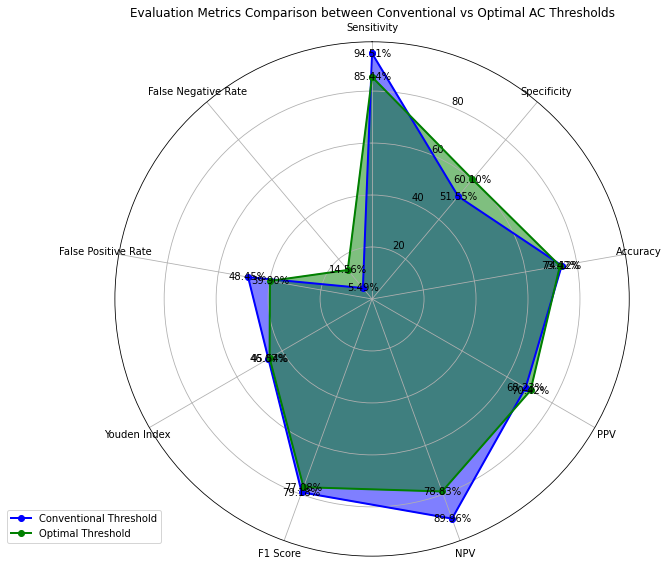

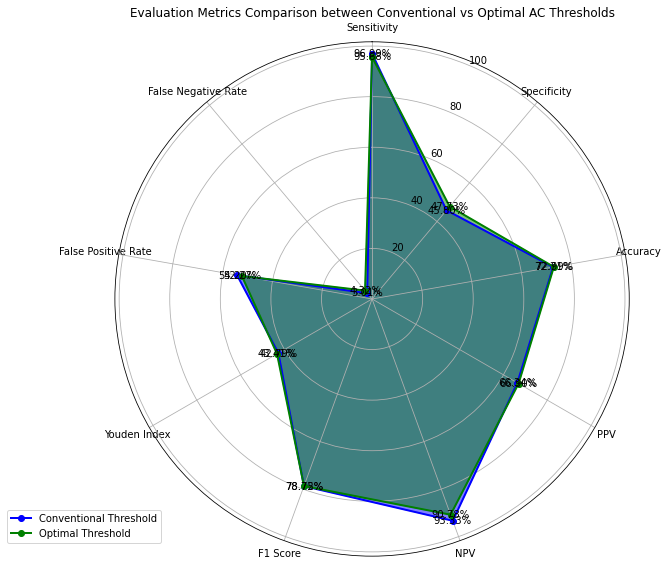

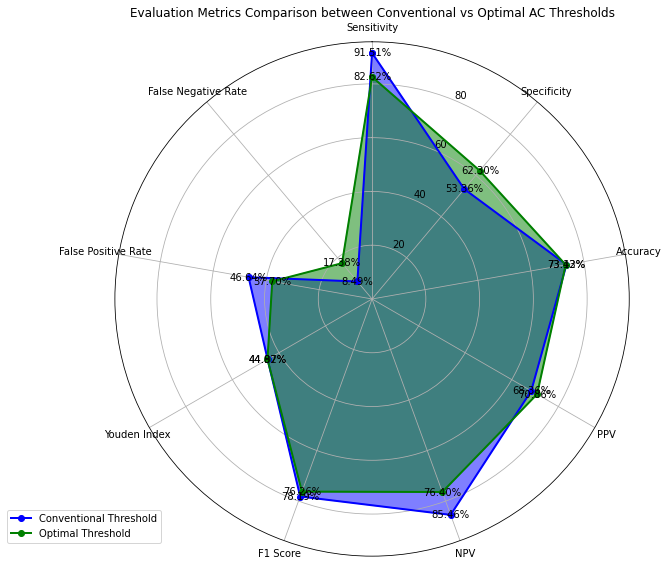

In [26]:
plot_radar_chart(eval_metrics_conv_ndh, eval_metrics_opt_ndh)
plot_radar_chart(eval_metrics_conv_dh, eval_metrics_opt_dh)
plot_radar_chart(eval_metrics_conv_bil, eval_metrics_opt_bil)

In [27]:
# Create a structure to save all the metrics 
metrics_dictionary = create_metrics_dictionary(eval_metrics_conv_ndh, eval_metrics_conv_dh,
                                               eval_metrics_conv_bil, eval_metrics_opt_ndh,
                                               eval_metrics_opt_dh, eval_metrics_opt_bil)

In [28]:
# Save metrics as csv file: evaluation metrics on unseen data 
save_metrics_dictionary_as_csv(metrics_dictionary, participant_path)
# Save optimal AC threhshold for this participant 
save_optimal_threshold(participant_path, opt_threshold_ndh, opt_threshold_dh)

The metrics dictionary has been saved as ../CreateStudy\H005\evaluation_metrics_AC.csv.
Thresholds saved successfully at: ../CreateStudy\H005\optimal_threshold_AC.csv


In [29]:
# Laterality metrics # 

In [30]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(count_brond_ndh['AC Brond'], count_brond_dh['AC Brond'])

In [31]:
magnitude_ratio = get_magnitude_ratio(count_brond_ndh['AC Brond'], count_brond_dh['AC Brond'])

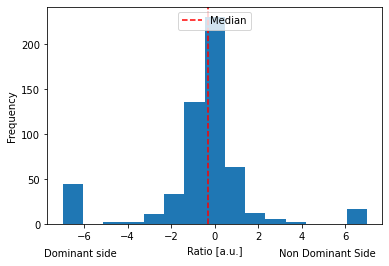

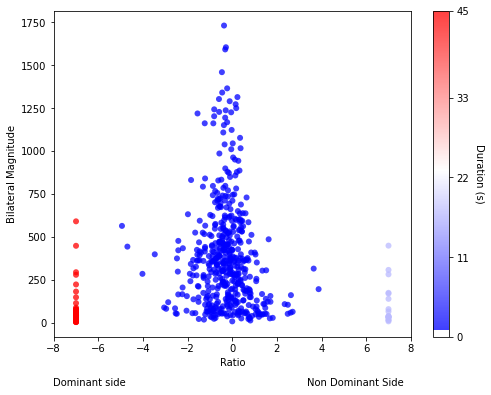

In [32]:
plot_distribution_ratio(magnitude_ratio)
plot_density(bilateral_magnitude, magnitude_ratio)